In [2]:
import tensorflow as tf

In [5]:
t=tf.constant([[1.,2.,3.],[4.,5.,6.]])

In [3]:
tf.constant(42)

<tf.Tensor: id=1, shape=(), dtype=int32, numpy=42>

In [6]:
t.shape

TensorShape([2, 3])

In [29]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import load_sample_image

In [5]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [6]:
china.shape, flower.shape

((427, 640, 3), (427, 640, 3))

In [13]:
images.shape

(2, 427, 640, 3)

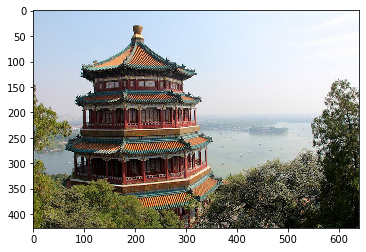

In [15]:
plt.imshow(china, cmap="gray")

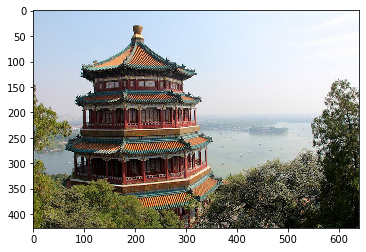

In [11]:
plt.imshow(china)

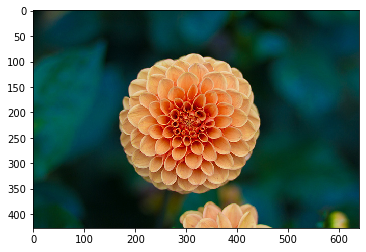

In [12]:
plt.imshow(flower)

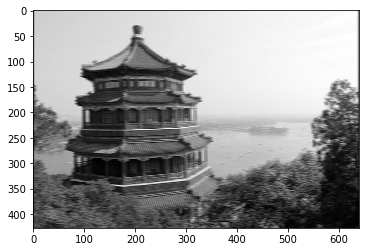

In [62]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

In [28]:
filters.shape

(7, 7, 3, 2)

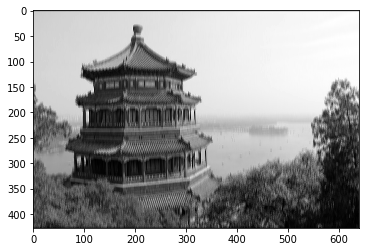

In [63]:
plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

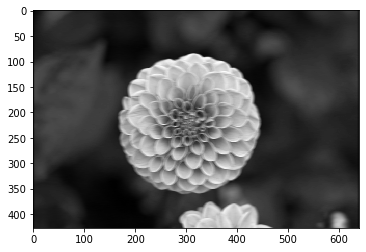

In [51]:
plt.imshow(outputs[1, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

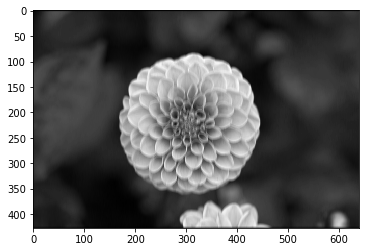

In [52]:
plt.imshow(outputs[1, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

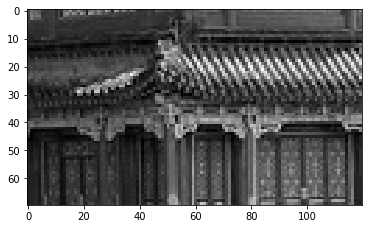

In [59]:
plt.imshow(images[0, :, :, 0][150:220, 130:250], cmap="gray")

figure for horizontal


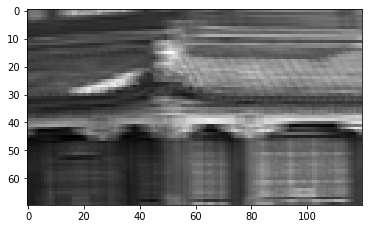

In [65]:
print("figure for horizontal")
plt.imshow(outputs[0, :, :, 1][150:220, 130:250], cmap="gray")

figure for vertical


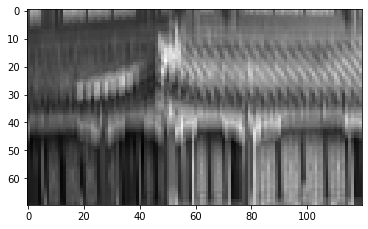

In [66]:
print("figure for vertical")
plt.imshow(outputs[0, :, :, 0][150:220, 130:250], cmap="gray")

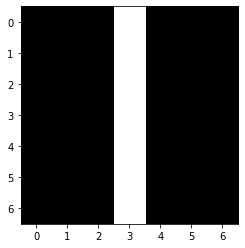

In [76]:
plt.imshow(filters[:,:,0,0], cmap="gray")

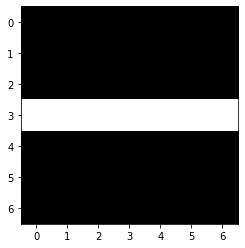

In [77]:
plt.imshow(filters[:,:,0,1], cmap="gray")

In [113]:
conv = keras.layers.Conv2D(filters=2, kernel_size=3, strides=1, padding="SAME", activation="relu")

In [ ]:
conv()

In [114]:
a = np.array([crop(image) for image in images], dtype=np.float32)
b = conv(a)

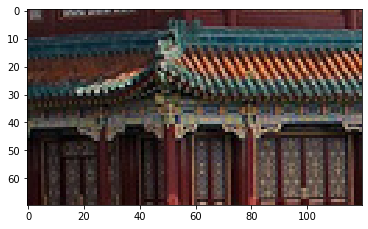

In [115]:
plt.imshow(a[0])
plt.show()

In [104]:
b[0].shape

TensorShape([70, 120, 32])

In [117]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [84]:
def crop(images):
    return images[150:220, 130:250]

In [85]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

In [118]:
cropped_images.shape

(2, 70, 120, 3)

In [119]:
output.shape

TensorShape([2, 35, 60, 3])

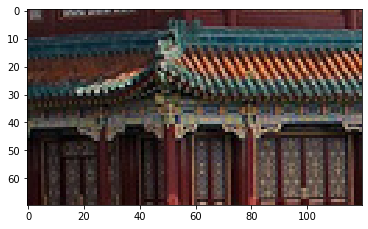

In [91]:
plt.imshow(cropped_images[0])  # plot the 1st image
plt.show()

In [105]:
output[0].shape

TensorShape([35, 60, 3])

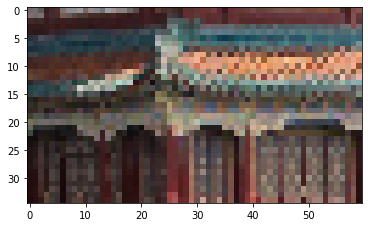

In [92]:
plt.imshow(output[0])  # plot the output for the 1st image
plt.show()

## ResNet-34

In [46]:
from functools import partial

In [8]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

In [9]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [10]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

## Using a pretrained Model

In [12]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [13]:
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

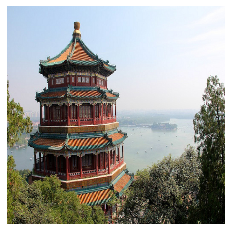

In [14]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


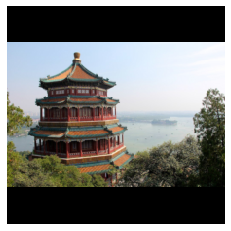

In [15]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

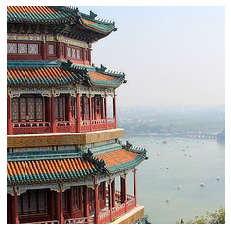

In [16]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

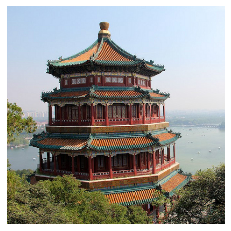

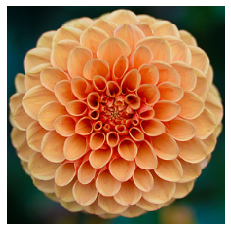

In [17]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [18]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [24]:
type(inputs), type(Y_proba)

(tensorflow.python.framework.ops.EagerTensor, numpy.ndarray)

In [38]:
print("because there are 1000 classes",Y_proba.shape) 

because there are 1000 classes (2, 1000)


In [39]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 5us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Pretrained Models for Transfer Learning

In [3]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset tf_flowers downloaded and prepared to C:\Users\Thinkpad\tensorflow_datasets\tf_flowers\1.0.0. Subsequent calls will reuse this data.


In [5]:
type(dataset)

dict

In [8]:
list(dataset.keys())

['train']

In [17]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [18]:
class_names = info.features["label"].names

In [19]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [20]:
n_classes = info.features['label'].num_classes

In [22]:
n_classes

5

In [23]:
dataset_size = info.splits["train"].num_examples

In [24]:
dataset_size

3670

In [27]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
'tf_flowers',
split=[
   tfds.Split.TRAIN.subsplit(tfds.percent[25:]),
   tfds.Split.TRAIN.subsplit(tfds.percent[10:25]),
   tfds.Split.TRAIN.subsplit(tfds.percent[:10])
],
with_info=True,
as_supervised=True,
)

In [37]:
metadata.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [39]:
type(raw_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

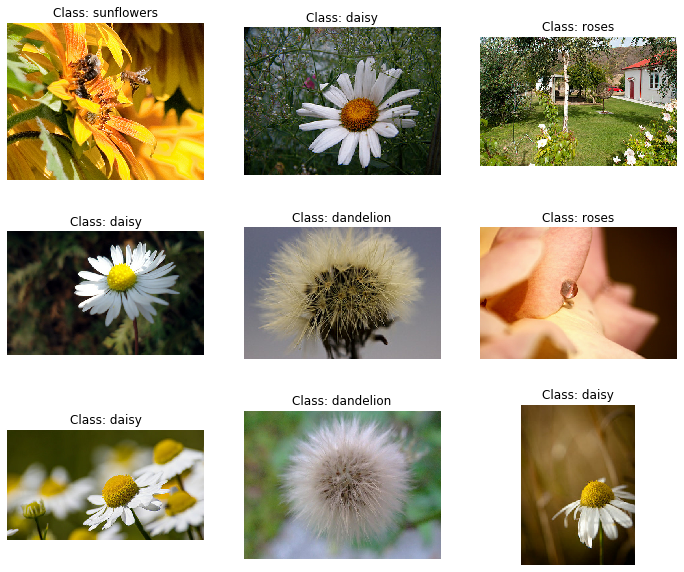

In [36]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in raw_train.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [40]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [41]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [43]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [44]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label 

In [47]:
batch_size = 32
train_set = raw_train.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = raw_validation.map(preprocess).batch(batch_size).prefetch(1)
test_set = raw_test.map(preprocess).batch(batch_size).prefetch(1)

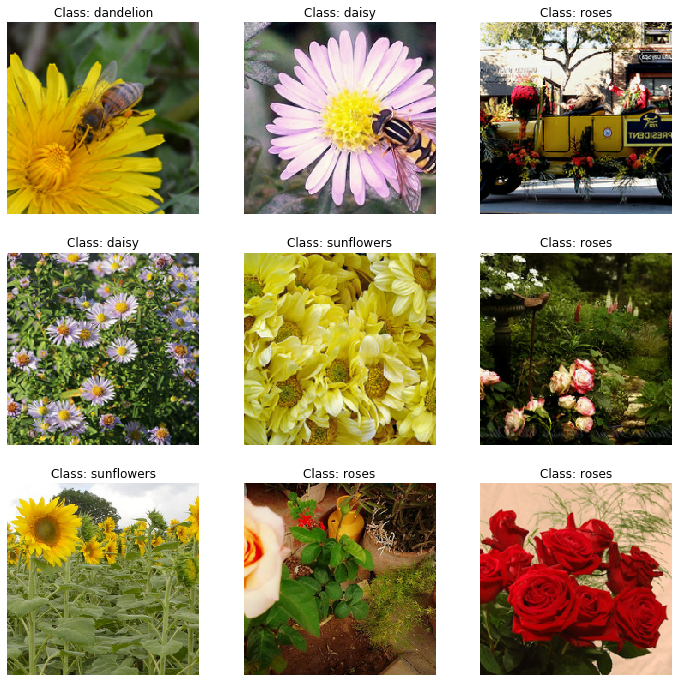

In [48]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

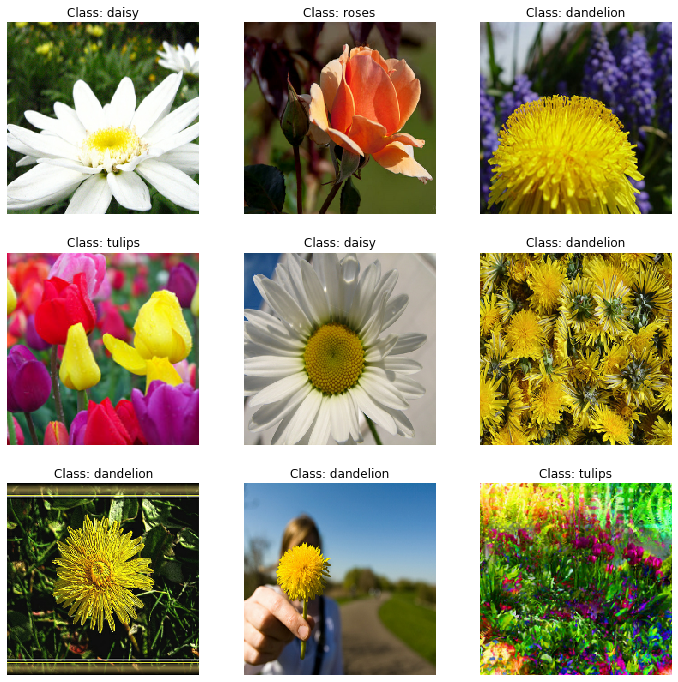

In [49]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [50]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 30s 0us/step


In [51]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
 3/86 [>.............................] - ETA: 23:49 - loss: 1.5252 - accuracy: 0.2656

KeyboardInterrupt: 